# Download & Imports

In [1]:
import cv2
import numpy as np
cv2.__version__

import requests
from os import mkdir
from os.path import basename, isdir

def download(url, location='.'):
    response = requests.get(url)
    if response.status_code != 200:
        raise IOError(f"response statis code is {response.status_code}")

    if not isdir(location):
        mkdir(location)

    path = location + '/' + basename(url)
    with open(path, "wb") as file:
        file.write(response.content)

    print(f'The file is successfully downloaded with path: \n{path}')

# загрузка модуля plot_tools:
url = "https://raw.githubusercontent.com/ordevoir/Miscellaneous/master/plot_tools.py"
download(url)

from plot_tools import show_image, show_image_bgr, show_images, show_images_bgr

The file is successfully downloaded with path: 
./plot_tools.py


In [2]:
LEFT, RIGHT = 500, 1500
TOP, BOTTOM = 0, 1000

def get_fragment(img):
    return img[TOP:BOTTOM, LEFT:RIGHT]
def fragments_of(*images):
    fragments = []
    for img in images:
        fragments.append(get_fragment(img))
    return fragments

# Read Images

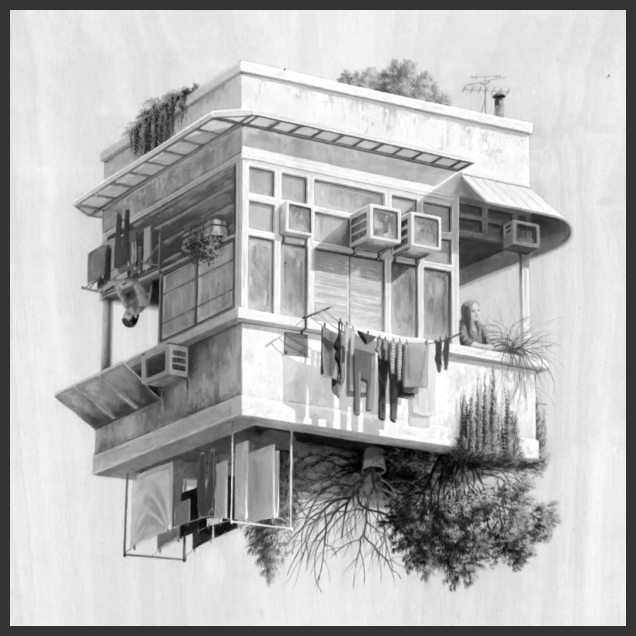

In [3]:
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread("./images/c_vidal-room_with_a_views.png")
img = img[..., 0]
img_16bit = (img * (2**16-1)).astype(np.uint16)
show_image(img_16bit)

## Thresholding

Напишем функцию, которая будет обнулять значение интенсивности для пискселей, значение которых меньше значения `threshold1`, а пиксели, интенсивность которых превышает `threshold2`, примут значение `threshold2`:

In [9]:
def thresholding(img, threshold1=None, threshold2=None, inplace=False):
    if threshold1:
        threshold1 = threshold1 * img.max()
    if threshold2:
        threshold2 = threshold2 * img.max()
        
    if inplace:
        if threshold1:
            img[img < threshold1] = 0
        if threshold2:
            img[img > threshold2] = threshold2
    else:
        new_img = img.copy()
        if threshold1:
            new_img[new_img < threshold1] = 0
        if threshold2:
            new_img[new_img > threshold2] = threshold2
        return new_img

## [Laplacian](https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html)

Фильтр Лапласа оценивает лапласиан в точке. Для того, чтобы посчитать вторые частные производные, можно воспользоваться одномерными фильтрами: 

In [4]:
ddx = np.array([1, -2, 1])
ddy = np.array([[ 1],
                [-2],
                [ 1]])

Для того, чотбы получить сумму вторых частных производных по $x$ и по $y$, можно сложить эти два фильтра, дополнив их нулями до формы `(3, 3)`:

In [6]:
ddx = np.array([[0,  0, 0],
                [1, -2, 1],
                [0,  0, 0] ])

ddy = np.array([[0,  1, 0],
                [0, -2, 0],
                [0,  1, 0] ])

laplace_kernel = ddx + ddy
laplace_kernel

array([[ 0,  1,  0],
       [ 1, -4,  1],
       [ 0,  1,  0]])

OpenCV предоставляет функцию [`cv2.Laplacian()`](https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html), для того, чтобы получить лапласиан изображения:

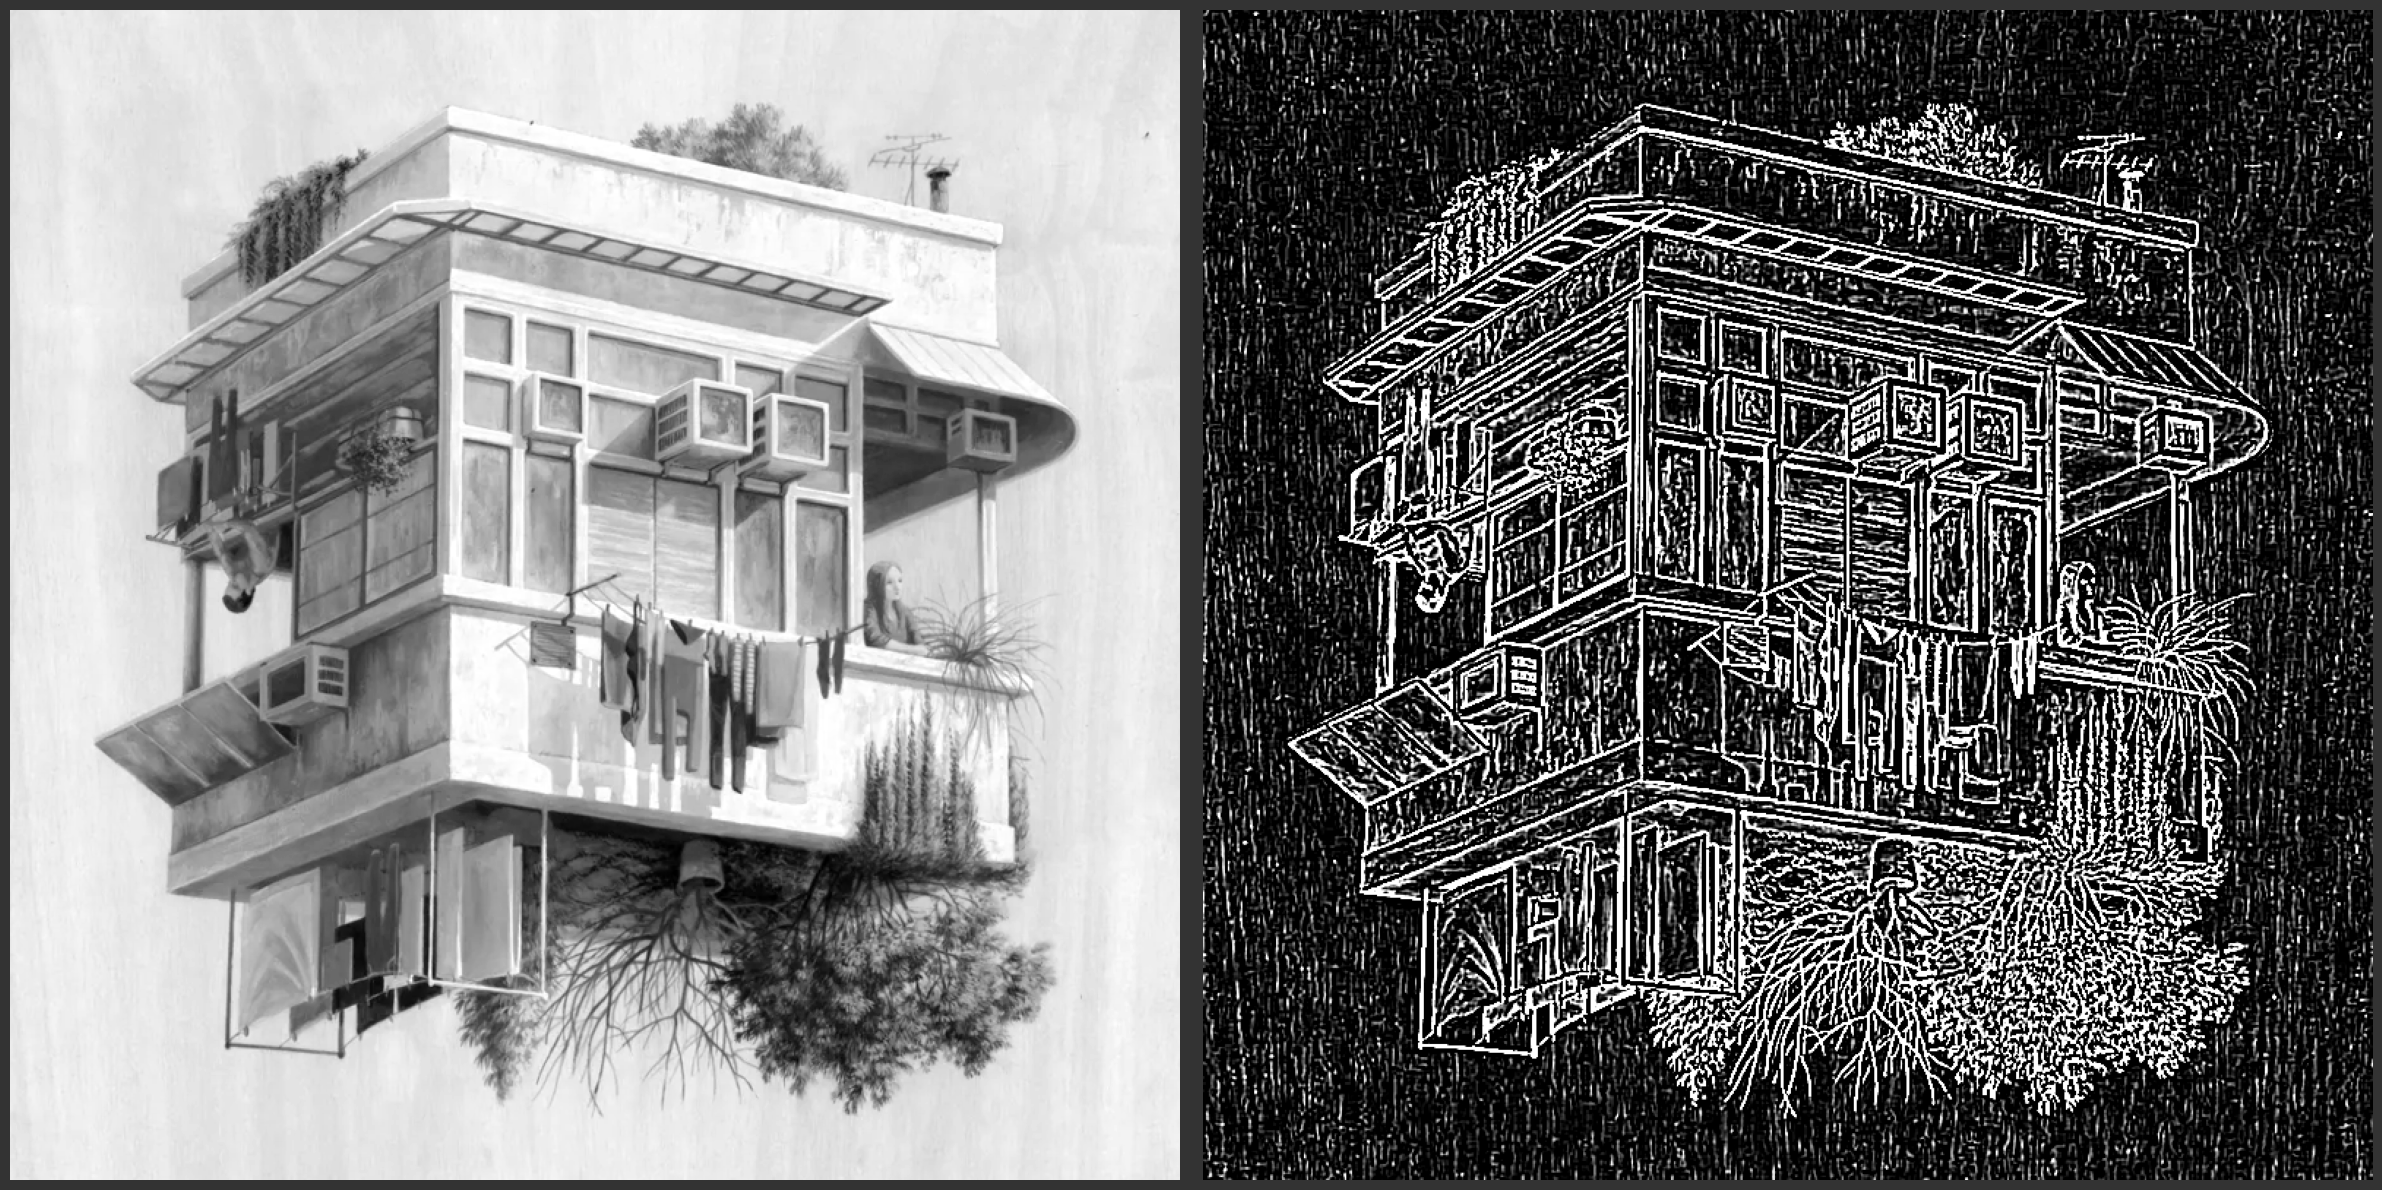

In [7]:
laplace = cv2.Laplacian(img_16bit, cv2.CV_16U, ksize=5)
show_images((img, laplace), size=12)

## LoG

[Laplacian of Gaussian](https://theailearner.com/2019/05/25/laplacian-of-gaussian-log/) представляет собой последовательное применение сглаживающего фильтра Гаусса и фильра Лапласа. Предварительное сглаживание позволяет уменьшить влияние шума. В данном случае перед гауссовым сглаживанием применяется еще и медианный фильтр, что позволяет значительно снизить шум. 

Получим LoG от изображения до выравнивания гистограммы и применим к нему `thresholding()`:

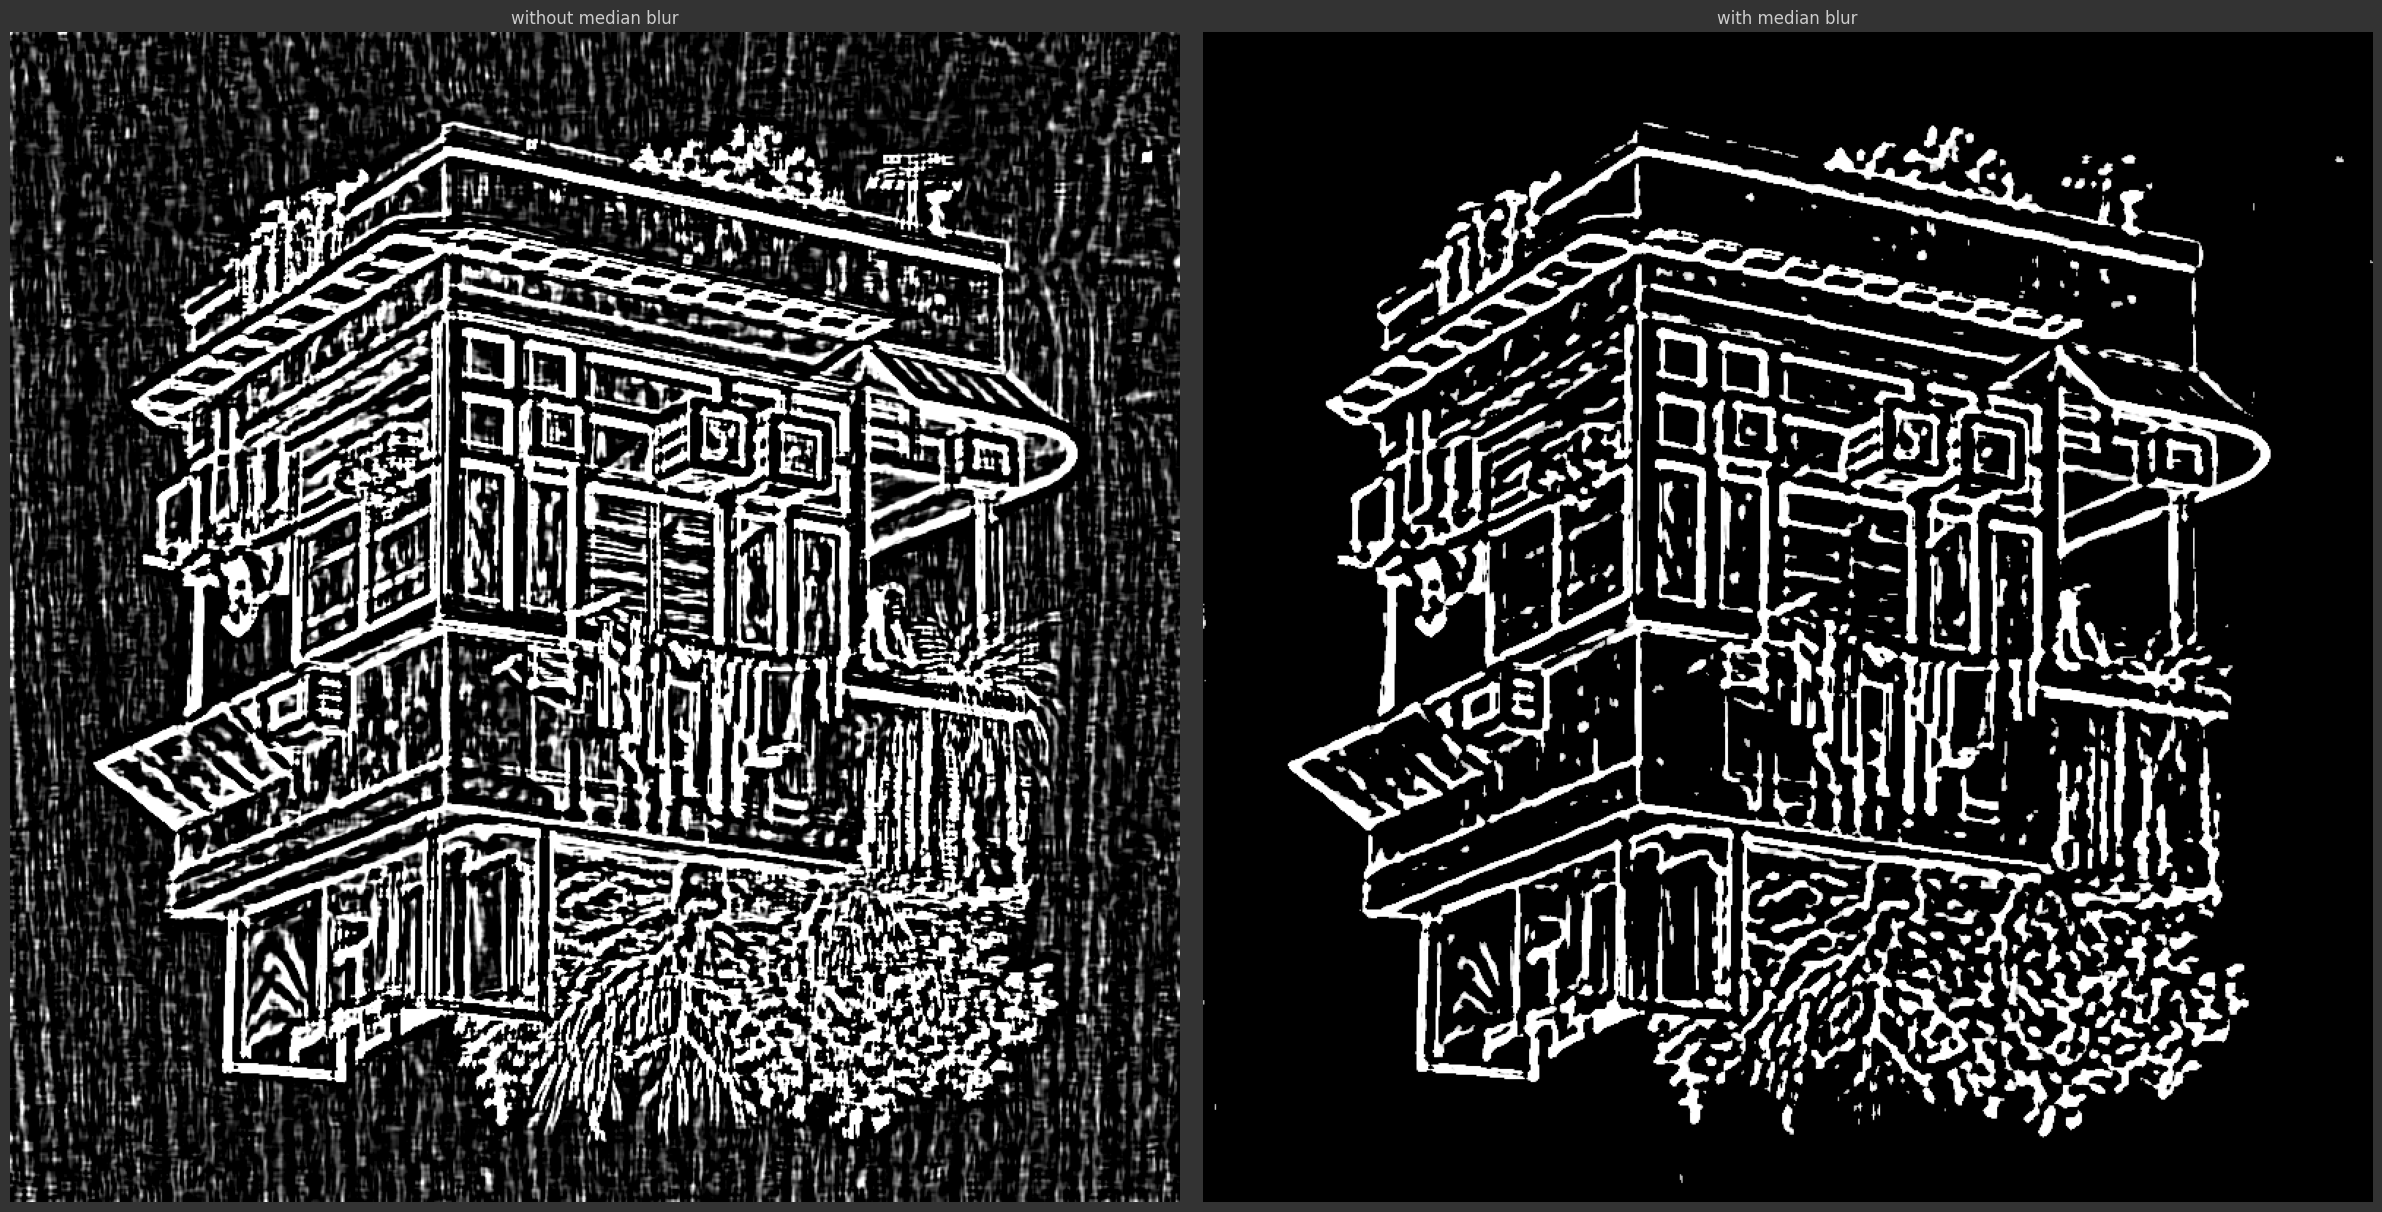

In [10]:
median_blured = cv2.medianBlur(img_16bit, 5)
kernel_size = 5
gaussian = cv2.GaussianBlur(img_16bit, ksize=(kernel_size+2, kernel_size+2), sigmaX=20.)
gaussian_of_median = cv2.GaussianBlur(median_blured, ksize=(kernel_size+2, kernel_size+2), sigmaX=20.)
LoG = cv2.Laplacian(gaussian, cv2.CV_16U, ksize=kernel_size)
LoG_of_median = cv2.Laplacian(gaussian_of_median, cv2.CV_16U, ksize=kernel_size)

show_images((thresholding(LoG, 0.005, 0.2), 
             thresholding(LoG_of_median, 0.2, 0.3)
             #  thresholding(sobel, threshold1=0.02, threshold2=0.2), 
             ),
            ("without median blur", "with median blur"),
            size=12)

Получим LoG от изображения после выравнивания гистограммы но без `thresholding()`:

## Sobel operator

Оператор Собеля представляет собой дифференциальный оператор, вычисляющий приближенное значение градиента яркости. Собеля в каждой точке изображения является либо вектор градиента яркости в этой точке, либо его норма. 

Рассмотрим горизонтальную и вертикальную ядра Sobel, которые соответственно дают оценку производных вдоль $x$ и $y$:

In [ ]:
G_x = np.array([[+1, 0, -1],
                [+2, 0, -2],
                [+1, 0, -1]], dtype=np.float32)

G_y = np.array([[+1, +2, +1],
                [ 0,  0,  0],
                [-1, -2, -1]])

Эти ядра могут быть комбинированы:
$$
\mathbf G = \sqrt{\mathbf G_x^2 + \mathbf G_y^2 }
$$

In [ ]:
median_blured = cv2.medianBlur(img, 5)
gaussian = cv2.GaussianBlur(median_blured, ksize=(7, 7), sigmaX=2.)

sobelx = cv2.filter2D(gaussian, -1, G_x)
sobely = cv2.filter2D(gaussian, -1, G_y)
sobel = np.sqrt(sobelx ** 2 + sobely ** 2) 

print(sobelx.min(), sobelx.max(), sobel.min(), sobel.max())
show_images((gaussian, sobel, 
             thresholding(sobel, threshold2=0.1),
            #  thresholding(sobel, threshold1=0.02, threshold2=0.2), 
             thresholding(sobel, threshold1=0.1, threshold2=0.5), 

             ), 
            size=12)

### [`Sobel`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d)

In [ ]:
kernel_size = 7
median_blured = cv2.medianBlur(img, 5)
gaussian = cv2.GaussianBlur(median_blured, ksize=(kernel_size, kernel_size), sigmaX=2.)
# sobel = cv2.Sobel(gaussian, ddepth=cv2.CV_32F, dx=1, dy=1, ksize=kernel_size)

sobelx = cv2.Sobel(gaussian, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=kernel_size)
sobely = cv2.Sobel(gaussian, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=kernel_size)
sobel = np.sqrt(sobelx**2 + sobely**2)

show_images((img, sobel,
             thresholding(sobel, threshold2=0.1),
             thresholding(sobel, threshold1=0.02, threshold2=0.2), 
             ), size=12)

## Canny Edge Detection

In [ ]:
kernel_size = 3
median_blured = cv2.medianBlur(img_16bit, 5)
gaussian = cv2.GaussianBlur(median_blured, ksize=(kernel_size, kernel_size), sigmaX=2.)

In [ ]:
img_8bit = (gaussian // 256).astype(np.uint8)
# canny = cv2.Canny(img_8bit, threshold1=5, threshold2=20)
canny = cv2.Canny(img_8bit, threshold1=25, threshold2=30)

show_images((img_8bit, canny), size=10)